# Has not been fully debugged/optimized

In [2]:
import numpy as np
import random
import copy
from scipy.stats import bernoulli
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
class Environment(object):
    '''General RL environment'''

    def __init__(self):
        pass

    def reset(self):
        pass

    def advance(self, action):
        '''
        Moves one step in the environment.
        Args:
            action
        Returns:
            reward - double - reward
            newState - int - new state
            pContinue - 0/1 - flag for end of the episode
        '''
        return 0, 0, 0

In [4]:
def make_riverSwim(epLen=20, nState=5):
    '''
    Makes the benchmark RiverSwim MDP.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment '''
    nAction = 2
    R_true = {}
    P_true = {}
    states = {}
    for s in range(nState):
        states[(s)] = 0.0
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    R_true[0, 0] = (5/1000, 0)
    R_true[nState - 1, 1] = (1, 0)

    # Transitions
    for s in range(nState):
        P_true[s, 0][max(0, s-1)] = 1.

    for s in range(1, nState - 1):
        P_true[s, 1][min(nState - 1, s + 1)] = 0.3
        P_true[s, 1][s] = 0.6
        P_true[s, 1][max(0, s-1)] = 0.1

    P_true[0, 1][0] = 0.3
    P_true[0, 1][1] = 0.7
    P_true[nState - 1, 1][nState - 1] = 0.9
    P_true[nState - 1, 1][nState - 2] = 0.1

    riverSwim = TabularMDP(nState, nAction, epLen)
    riverSwim.R = R_true
    riverSwim.P = P_true
    riverSwim.states = states
    riverSwim.reset()

    return riverSwim

class TabularMDP(Environment):
    '''
    Tabular MDP
    R - dict by (s,a) - each R[s,a] = (meanReward, sdReward)
    P - dict by (s,a) - each P[s,a] = transition vector size S
    '''

    def __init__(self, nState, nAction, epLen):
        '''
        Initialize a tabular episodic MDP
        Args:
            nState  - int - number of states
            nAction - int - number of actions
            epLen   - int - episode length
        Returns:
            Environment object
        '''

        self.nState = nState
        self.nAction = nAction
        self.epLen = epLen

        self.timestep = 0
        self.state = 0

        # Now initialize R and P
        self.R = {}
        self.P = {}
        self.states = {}
        for state in range(nState):
            for action in range(nAction):
                self.R[state, action] = (1, 1)
                self.P[state, action] = np.ones(nState) / nState
                
    def reset(self):
        "Resets the Environment"
        self.timestep = 0
        self.state = 0
        
    def advance(self,action):
        '''
        Move one step in the environment
        Args:
        action - int - chosen action
        Returns:
        reward - double - reward
        newState - int - new state
        episodeEnd - 0/1 - flag for end of the episode
        '''
        if self.R[self.state, action][1] < 1e-9:
            # Hack for no noise
            reward = self.R[self.state, action][0]
        else:
            reward = np.random.normal(loc=self.R[self.state, action][0],
                                      scale=self.R[self.state, action][1])
        #print(self.state, action, self.P[self.state, action])
        newState = np.random.choice(self.nState, p=self.P[self.state, action])
        
        # Update the environment
        self.state = newState
        self.timestep += 1

        episodeEnd = 0
        if self.timestep == self.epLen:
            episodeEnd = 1
            #newState = None
            self.reset()

        return reward, newState, episodeEnd
    
    def argmax(self,b):
        #print(b)
        return np.random.choice(np.where(b == b.max())[0])

In [5]:
class deep_sea(Environment):
    '''
    Description:
        A deep sea environment, where a diver goes
        down and each time and she needs to make a
        decision to go left or right.
        environment terminates after fixed time step

    Observation:
        [horizontal position, vertical position]

    Actions:
        2 possible actions:
        0 - left
        1 - right

    Starting State:
        start at position 0, time step 0

    Episode termination:
        Env terminates after fixed number of time steps
    '''

    def __init__(self, num_steps):
        '''
        Inputs:
            num_steps: An integer that represents the size of the DeepSea environment
        '''
        self.num_steps = num_steps
        self.epLen = num_steps
        self.flip_mask = 2*np.random.binomial(1,0.5,(num_steps,num_steps))-1
        self.nAction = 2
        self.nState = pow(num_steps,2)
        self.epLen = num_steps
        self.R = {}
        self.states = {}
        for s in range(self.num_steps):
            for s_ in range(self.num_steps):
                self.R[(s,s_), 0] = (0, 0)
                self.R[(s,s_), 1] = (-0.01/self.nState, 0)
                self.states[(s,s_)] = 0
        self.R[(self.num_steps-1,self.num_steps-1),1] = (0.99,0)

    def name(self):
        return  "deep sea"

    def reset(self):
        self.state = (0,0)
        self.timestep = 0
        return copy.deepcopy(self.state)

    def advance(self,action):
        assert action in [0,1], "invalid action"
        self.state_prev = self.state
        step_horizontal = (2*action-1)
        horizontal = max(self.state[0] + step_horizontal, 0)
        vertical = self.state[1] + 1
        done =  bool(vertical == self.num_steps)
        self.state = (horizontal, vertical)
        self.timestep += 1
        return self.R[self.state_prev,action][0], copy.deepcopy(self.state), done

    def argmax(self,b):
        return np.random.choice(np.where(b == b.max())[0])


In [6]:
class LSVI_UCB(object):
    def __init__(self,env,K,c):
        self.env = env
        self.K = K
        self.d = self.env.nState * self.env.nAction
        self.c = c
        self.p = 10/self.K
        self.lam = 1.0
        self.Lam = [(self.lam*np.identity(self.d)) for h in range(env.epLen)]
        self.phi = np.identity(self.d)
        self.Q = {(h,s,a): 0.0 for h in range(self.env.epLen+1) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        self.w = [np.zeros(self.d) for h in range(env.epLen)]
        self.wsum = [np.zeros(self.d) for h in range(env.epLen)]
        self.buffer = {h: [] for h in range(self.env.epLen)}
        self.sigma = {}
        self.createSigma()
        
    def learn(self,s,a,r,s_,h):
        self.Lam[h] += np.outer(self.phi[self.sigma[s,a]],self.phi[self.sigma[s,a]])
        self.wsum[h] += self.phi[self.sigma[s,a]] * (r + \
                                max(np.array([self.Q[(h+1,s_,a_)] for a_ in range(self.env.nAction)])))
        self.w[h] = np.matmul(np.linalg.inv(self.Lam[h]),self.wsum[h])

    
    def update_Q(self,k):
        for h in range(env.epLen-1,-1,-1):
            for s in self.env.states.keys():
                for a in range(env.nAction):
                    min1 = np.dot(self.w[h],self.phi[self.sigma[s,a]]) + self.Beta(h,k)* \
                                  np.sqrt(np.dot(np.dot(self.phi[self.sigma[s,a]].T,np.linalg.inv(self.Lam[h])) \
                                                  ,self.phi[self.sigma[s,a]]))
                    min2 = self.env.epLen
                    self.Q[h,s,a] = self.proj(min1,0,self.env.epLen)
    
    def Beta(self,h,k):
        
        #first = np.sqrt(self.lam)*self.c
        #second = np.sqrt(2*np.log(1/self.delta) + self.d*np.log((self.d*self.lam + k*self.L*self.L)/(self.d*self.lam)))
        #second = np.sqrt(2*np.log(1/self.p) + np.log(k*min(np.linalg.det(self.Lam[h]),pow(10,10)) / (pow(self.lam,self.d))))
        #return first + second
        
        
        itoa = np.log(2*self.d*self.K*self.env.epLen/self.p)
        return self.c*self.d*self.env.epLen*np.sqrt(itoa)
    
    def createSigma(self):
        '''
        A simple function that creates sigma according to Appendix B.
        Here sigma is a dictionary who inputs is a tuple (s,a,s') and stores
        the interger index to be used in our basis model P.
        '''
        i = 0
        for s in self.env.states.keys():
            for a in range(env.nAction):
                self.sigma[(s,a)] = int(i)
                i += 1
    
    def act(self,s,h):
        x = np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)])
        return self.env.argmax(x)
    
    def proj(self,x, lo, hi):
        return max(min(x,hi),lo)

In [10]:
env = make_riverSwim(epLen = 20, nState = 4)
K = 10000
c = 1.0
agent = LSVI_UCB(env,K,c)

In [11]:
R = 0
Rvec = []
for k in (range(1,K+1)):
    env.reset()
    done = 0
    while done != 1:
        s = env.state
        h = env.timestep
        a = agent.act(s,h)
        if k == K:
            print(a)
        r,s_,done = env.advance(a)
        R+=r
        agent.learn(s,a,r,s_,h)
    Rvec.append(R)
    agent.update_Q(k)



0
1
1
1
1
0
0
1
0
1
1
1
0
0
0
1
0
1
1
0



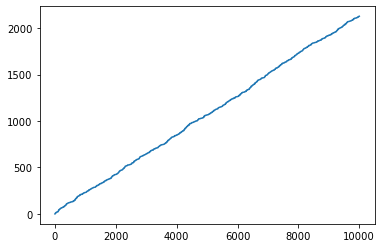

In [12]:
plt.plot(Rvec)

In [13]:
agent.Q

{(0, 0, 0): 20,
 (0, 0, 1): 20,
 (0, 1, 0): 20,
 (0, 1, 1): 20,
 (0, 2, 0): 20,
 (0, 2, 1): 20,
 (0, 3, 0): 20,
 (0, 3, 1): 20,
 (1, 0, 0): 20,
 (1, 0, 1): 20,
 (1, 1, 0): 20,
 (1, 1, 1): 20,
 (1, 2, 0): 20,
 (1, 2, 1): 20,
 (1, 3, 0): 20,
 (1, 3, 1): 20,
 (2, 0, 0): 20,
 (2, 0, 1): 20,
 (2, 1, 0): 20,
 (2, 1, 1): 20,
 (2, 2, 0): 20,
 (2, 2, 1): 20,
 (2, 3, 0): 20,
 (2, 3, 1): 20,
 (3, 0, 0): 20,
 (3, 0, 1): 20,
 (3, 1, 0): 20,
 (3, 1, 1): 20,
 (3, 2, 0): 20,
 (3, 2, 1): 20,
 (3, 3, 0): 20,
 (3, 3, 1): 20,
 (4, 0, 0): 20,
 (4, 0, 1): 20,
 (4, 1, 0): 20,
 (4, 1, 1): 20,
 (4, 2, 0): 20,
 (4, 2, 1): 20,
 (4, 3, 0): 20,
 (4, 3, 1): 20,
 (5, 0, 0): 20,
 (5, 0, 1): 20,
 (5, 1, 0): 20,
 (5, 1, 1): 20,
 (5, 2, 0): 20,
 (5, 2, 1): 20,
 (5, 3, 0): 20,
 (5, 3, 1): 20,
 (6, 0, 0): 20,
 (6, 0, 1): 20,
 (6, 1, 0): 20,
 (6, 1, 1): 20,
 (6, 2, 0): 20,
 (6, 2, 1): 20,
 (6, 3, 0): 20,
 (6, 3, 1): 20,
 (7, 0, 0): 20,
 (7, 0, 1): 20,
 (7, 1, 0): 20,
 (7, 1, 1): 20,
 (7, 2, 0): 20,
 (7, 2, 1): 20,
 (7, 3, 

In [92]:
print(a)

1
